In [18]:
import sys
import os
import importlib
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pylab
from sklearn.decomposition import PCA
from sklearn.utils import shuffle

# pyaldata
sys.path.append("/home/zms24/Desktop") 
import PyalData.pyaldata as pyal # type:ignore

# tools functions
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from tools.curbd import curbd
from tools.dsp.preprocessing import preprocess
from tools.rnn_and_curbd import rnn as rnnz
from tools.rnn_and_curbd import plotting as pltz
from tools.rnn_and_curbd import model_analysis as analyz
from tools.rnn_and_curbd import curbd as curbdz

# Reload modules
importlib.reload(rnnz)
importlib.reload(pltz)
importlib.reload(analyz)
importlib.reload(curbdz)

np.random.seed(0)

#### color palette

In [2]:
curbd_colors = {'MOp': "#3681D2", 'M1': "#3681D2", 'SSp': '#f4a261', 'CP': "#8ed74d", 'VAL': '#e76f51', 'Thal': '#e76f51','Dls': "#8ed74d"}
model_color = "#0000D0"
exp_color = '#232333'
trial_color = '#98fb98'
top_sol_color = "#ed6bbe"
bottom_sol_color = "#b66cea"
color_palette = {'curbd_colors': curbd_colors, 
                 'model_color': model_color, 
                 'exp_color': exp_color,
                 'trial_color': trial_color,
                 'top_sol_color': top_sol_color,
                 'bottom_sol_color': bottom_sol_color
                 }

### M044 models

In [3]:
filename = 'rnn_model_M044_2024_12_04_09_30.mat'
path = os.path.join("/home/zms24/Desktop/rnn_models/", filename)

data = loadmat(path, simplify_cells=True)
rnn_model = data['rnn_model']

In [4]:
pyal_dict_44_0 = rnnz.process_pyal_M044_files("M044_2024_12_04_09_30_pyaldata.mat", rnn_model)

field values_before_camera_trigger could not be converted to int.
field idx_before_camera_trigger could not be converted to int.
array field all_KSLabel could not be converted to int.


/home/zms24/Desktop/PyalData/pyaldata/firing_rates.py:108: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn(


Combined every 3 bins
Resulting all_spikes ephys data shape is (NxT): (474, 133)
Trial length: 133


### M061 models

In [5]:
fname0 = 'rnn_model_M061_2025_03_04_10_00.mat'
fname1 = 'rnn_model_M061_2025_03_06_14_00.mat'
path0 = os.path.join("/home/zms24/Desktop/rnn_models/", fname0)
path1 = os.path.join("/home/zms24/Desktop/rnn_models/", fname1)

data0 = loadmat(path0, simplify_cells=True)
data1 = loadmat(path1, simplify_cells=True)
rnn_model0 = data0['rnn_model']
rnn_model1 = data1['rnn_model']

In [6]:
pyal_dict_61_0 = rnnz.process_pyal_M061_M062_files(fname0, rnn_model0)
pyal_dict_61_1 = rnnz.process_pyal_M061_M062_files(fname1, rnn_model1)

field values_Sol_direction could not be converted to int.
field idx_Sol_direction could not be converted to int.
field values_Sol_duration could not be converted to int.
field idx_Sol_duration could not be converted to int.
field idx_sol_on could not be converted to int.
array field SSp_ul_KSLabel could not be converted to int.
array field all_KSLabel could not be converted to int.
array field Thal_KSLabel could not be converted to int.
array field MOp_KSLabel could not be converted to int.
array field CP_KSLabel could not be converted to int.
field idx_motion could not be converted to int.
array field SSp_ul_KSLabel could not be converted to int.
array field all_KSLabel could not be converted to int.
array field Thal_KSLabel could not be converted to int.
array field MOp_KSLabel could not be converted to int.
array field CP_KSLabel could not be converted to int.
field values_before_camera_trigger could not be converted to int.
field idx_before_camera_trigger could not be converted to 

/home/zms24/Desktop/PyalData/pyaldata/firing_rates.py:108: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/firing_rates.py:108: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/firing_rates.py:108: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/firing_rates.py:108: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn(


Combined every 3 bins
Resulting SSp_ul_spikes ephys data shape is (NxT): (59, 200)
Resulting Thal_spikes ephys data shape is (NxT): (240, 200)
Resulting MOp_spikes ephys data shape is (NxT): (206, 200)
Resulting CP_spikes ephys data shape is (NxT): (356, 200)
Trial length: 200
field values_before_camera_trigger could not be converted to int.
field idx_before_camera_trigger could not be converted to int.
array field SSp_KSLabel could not be converted to int.
array field VAL_KSLabel could not be converted to int.
array field all_KSLabel could not be converted to int.
array field MOp_KSLabel could not be converted to int.
array field CP_KSLabel could not be converted to int.
array field GPe_KSLabel could not be converted to int.
array field SSp_KSLabel could not be converted to int.
array field VAL_KSLabel could not be converted to int.
array field all_KSLabel could not be converted to int.
array field MOp_KSLabel could not be converted to int.
array field CP_KSLabel could not be converte

/home/zms24/Desktop/PyalData/pyaldata/utils.py:155: UserWarning: values_MotSen1_X might be a time-varying field. It matches the length of SSp_spikes on 99.85052316890882% of trials
  warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/utils.py:155: UserWarning: idx_MotSen1_X might be a time-varying field. It matches the length of SSp_spikes on 99.85052316890882% of trials
  warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/utils.py:155: UserWarning: values_MotSen1_Y might be a time-varying field. It matches the length of SSp_spikes on 99.85052316890882% of trials
  warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/utils.py:155: UserWarning: idx_MotSen1_Y might be a time-varying field. It matches the length of SSp_spikes on 99.85052316890882% of trials
  warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/firing_rates.py:108: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/firing_rates.py:108

Combined every 3 bins
Resulting SSp_spikes ephys data shape is (NxT): (69, 200)
Resulting VAL_spikes ephys data shape is (NxT): (168, 200)
Resulting MOp_spikes ephys data shape is (NxT): (178, 200)
Resulting CP_spikes ephys data shape is (NxT): (172, 200)
Resulting GPe_spikes ephys data shape is (NxT): (120, 200)
Trial length: 200


In [7]:
arr = pyal_dict_61_1['regions_arr']
filtered_arr = arr[arr[:, 0] != 'GPe']
pyal_dict_61_1['regions_arr'] = filtered_arr

### M062 models

In [8]:
fname2 = 'rnn_model_M062_2025_03_19_14_00.mat'
fname3 = 'rnn_model_M062_2025_03_20_14_00.mat'
fname4 = 'rnn_model_M062_2025_03_21_14_00.mat'
path2 = os.path.join("/home/zms24/Desktop/rnn_models/", fname2)
path3 = os.path.join("/home/zms24/Desktop/rnn_models/", fname3)
path4 = os.path.join("/home/zms24/Desktop/rnn_models/", fname4)

data2 = loadmat(path2, simplify_cells=True)
data3 = loadmat(path3, simplify_cells=True)
data4 = loadmat(path4, simplify_cells=True)
rnn_model2 = data2['rnn_model']
rnn_model3 = data3['rnn_model']
rnn_model4 = data4['rnn_model']

In [9]:
pyal_dict_62_0 = rnnz.process_pyal_M061_M062_files(fname2, rnn_model2)
pyal_dict_62_1 = rnnz.process_pyal_M061_M062_files(fname3, rnn_model3)
pyal_dict_62_2 = rnnz.process_pyal_M061_M062_files(fname4, rnn_model4)

array field all_KSLabel could not be converted to int.
array field VAL_KSLabel could not be converted to int.
array field SSp_KSLabel could not be converted to int.
array field CP_KSLabel could not be converted to int.
array field MOp_KSLabel could not be converted to int.
field values_Sol_direction could not be converted to int.
field idx_Sol_direction could not be converted to int.
field values_Sol_duration could not be converted to int.
field idx_Sol_duration could not be converted to int.
field idx_sol_on could not be converted to int.
array field all_KSLabel could not be converted to int.
array field VAL_KSLabel could not be converted to int.
array field SSp_KSLabel could not be converted to int.
array field CP_KSLabel could not be converted to int.
array field MOp_KSLabel could not be converted to int.
field values_before_camera_trigger could not be converted to int.
field idx_before_camera_trigger could not be converted to int.
array field all_KSLabel could not be converted to i

/home/zms24/Desktop/PyalData/pyaldata/utils.py:155: UserWarning: values_MotSen1_X might be a time-varying field. It matches the length of VAL_spikes on 99.86149584487535% of trials
  warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/utils.py:155: UserWarning: idx_MotSen1_X might be a time-varying field. It matches the length of VAL_spikes on 99.86149584487535% of trials
  warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/utils.py:155: UserWarning: values_MotSen1_Y might be a time-varying field. It matches the length of VAL_spikes on 99.86149584487535% of trials
  warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/utils.py:155: UserWarning: idx_MotSen1_Y might be a time-varying field. It matches the length of VAL_spikes on 99.86149584487535% of trials
  warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/firing_rates.py:108: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/firing_rates.py:108

Combined every 3 bins
Resulting VAL_spikes ephys data shape is (NxT): (198, 200)
Resulting SSp_spikes ephys data shape is (NxT): (95, 200)
Resulting CP_spikes ephys data shape is (NxT): (307, 200)
Resulting MOp_spikes ephys data shape is (NxT): (210, 200)
Trial length: 200
field values_before_camera_trigger could not be converted to int.
field idx_before_camera_trigger could not be converted to int.
array field VAL_KSLabel could not be converted to int.
array field SSp_KSLabel could not be converted to int.
array field all_KSLabel could not be converted to int.
array field MOp_KSLabel could not be converted to int.
array field CP_KSLabel could not be converted to int.
array field VAL_KSLabel could not be converted to int.
array field SSp_KSLabel could not be converted to int.
array field all_KSLabel could not be converted to int.
array field MOp_KSLabel could not be converted to int.
array field CP_KSLabel could not be converted to int.
field values_Sol_direction could not be converted

/home/zms24/Desktop/PyalData/pyaldata/utils.py:155: UserWarning: values_MotSen1_X might be a time-varying field. It matches the length of VAL_spikes on 99.85955056179775% of trials
  warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/utils.py:155: UserWarning: idx_MotSen1_X might be a time-varying field. It matches the length of VAL_spikes on 99.85955056179775% of trials
  warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/utils.py:155: UserWarning: values_MotSen1_Y might be a time-varying field. It matches the length of VAL_spikes on 99.85955056179775% of trials
  warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/utils.py:155: UserWarning: idx_MotSen1_Y might be a time-varying field. It matches the length of VAL_spikes on 99.85955056179775% of trials
  warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/firing_rates.py:108: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/firing_rates.py:108

Combined every 3 bins
Resulting VAL_spikes ephys data shape is (NxT): (155, 200)
Resulting SSp_spikes ephys data shape is (NxT): (118, 200)
Resulting MOp_spikes ephys data shape is (NxT): (163, 200)
Resulting CP_spikes ephys data shape is (NxT): (356, 200)
Trial length: 200
field values_before_camera_trigger could not be converted to int.
field idx_before_camera_trigger could not be converted to int.
array field VAL_KSLabel could not be converted to int.
array field SSp_KSLabel could not be converted to int.
array field all_KSLabel could not be converted to int.
array field CP_KSLabel could not be converted to int.
array field MOp_KSLabel could not be converted to int.
field values_Sol_direction could not be converted to int.
field idx_Sol_direction could not be converted to int.
field values_Sol_duration could not be converted to int.
field idx_Sol_duration could not be converted to int.
field idx_sol_on could not be converted to int.
array field VAL_KSLabel could not be converted to 

/home/zms24/Desktop/PyalData/pyaldata/utils.py:155: UserWarning: values_MotSen1_X might be a time-varying field. It matches the length of VAL_spikes on 99.85875706214689% of trials
  warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/utils.py:155: UserWarning: idx_MotSen1_X might be a time-varying field. It matches the length of VAL_spikes on 99.85875706214689% of trials
  warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/utils.py:155: UserWarning: values_MotSen1_Y might be a time-varying field. It matches the length of VAL_spikes on 99.85875706214689% of trials
  warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/utils.py:155: UserWarning: idx_MotSen1_Y might be a time-varying field. It matches the length of VAL_spikes on 99.85875706214689% of trials
  warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/firing_rates.py:108: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn(
/home/zms24/Desktop/PyalData/pyaldata/firing_rates.py:108

Combined every 3 bins
Resulting VAL_spikes ephys data shape is (NxT): (122, 200)
Resulting SSp_spikes ephys data shape is (NxT): (66, 200)
Resulting CP_spikes ephys data shape is (NxT): (280, 200)
Resulting MOp_spikes ephys data shape is (NxT): (179, 200)
Trial length: 200


In [10]:
def plot_model_accuracy_by_group(models_dict):
    """
    models_dict: dict with group names as keys and list of RNN models as values.
    Example: {
        "M061": [model1, model2, ...],
        "M062": [model3, model4, ...]
    }
    """
    fig = pylab.figure(figsize=[2, 3], dpi = 300)

    colors = {
        "M044": "#6A6AFF",
        "M061": "#0000D0",
        "M062": "#00007F"}
    mouse_labels = {'M044': 'Mouse 1', 'M061': 'Mouse 2', 'M062': 'Mouse 3'}
    ax1 = fig.add_subplot(2, 1, 1)
    ax2 = fig.add_subplot(2, 1, 2)

    for group_name, models in models_dict.items():
        color = colors.get(group_name, None)

        pVars_array = np.array([m['pVars'] for m in models])
        chi2s_array = np.array([m['chi2s'] for m in models])

        pVars_mean = np.mean(pVars_array, axis=0)
        pVars_sem = np.std(pVars_array, axis=0, ddof=1) / np.sqrt(len(models))

        chi2s_mean = np.mean(chi2s_array, axis=0)
        chi2s_sem = np.std(chi2s_array, axis=0, ddof=1) / np.sqrt(len(models))

        iterations = np.arange(len(pVars_mean))

        # Plot pVar
        ax1.plot(iterations, pVars_mean, label= mouse_labels[group_name], color=color)
        ax1.fill_between(iterations, pVars_mean - pVars_sem, pVars_mean + pVars_sem, color=color, alpha=0.3)

        # Plot chi²
        ax2.plot(iterations, chi2s_mean, label=mouse_labels[group_name], color=color)
        ax2.fill_between(iterations, chi2s_mean - chi2s_sem, chi2s_mean + chi2s_sem, color=color, alpha=0.3)

    # ax1.set_ylabel("pVar", fontsize=14)
    # ax1.set_xlabel("Iterations", fontsize=14)
    ax1.set_ylim(0, 1)
    # ax1.legend()

    # ax2.set_ylabel("chi²", fontsize=14)
    # ax2.set_xlabel("Iterations", fontsize=14)
    ax2.set_ylim(0, 5)
    # ax2.legend( frameon=False, bbox_to_anchor=(1.3, 1))

    fig.tight_layout()
    # fig.suptitle("RNN Model Accuracy — M061 vs M062", y=1.05)

/home/zms24/miniconda3/envs/zofia_earthquake_env/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/zms24/miniconda3/envs/zofia_earthquake_env/lib/python3.10/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


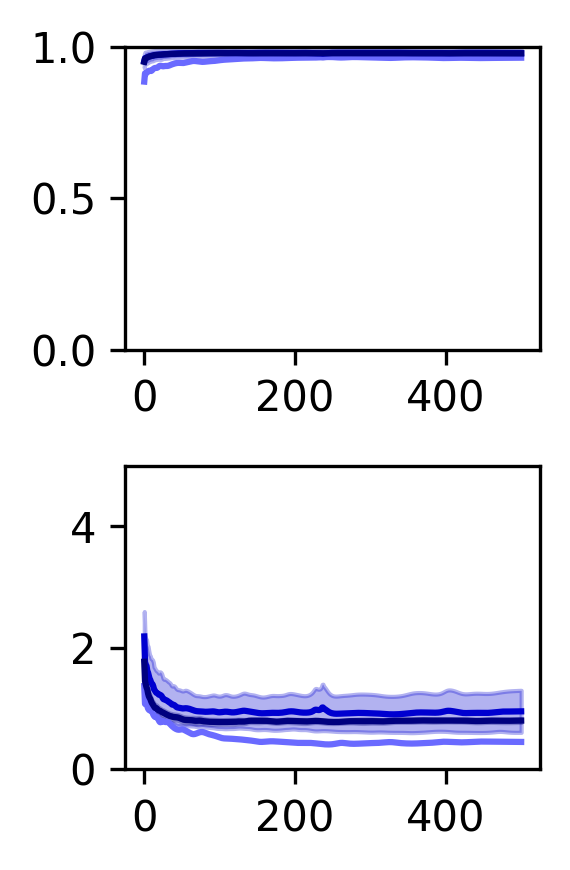

In [11]:
rnn_models_dict = {'M044': [rnn_model],
                   'M061': [rnn_model0, rnn_model1],
                   'M062': [rnn_model2, rnn_model3, rnn_model4]}
plot_model_accuracy_by_group(rnn_models_dict)


## CCA analysis

In [25]:
def cca_comparison(models_dict):
    fig = plt.figure(figsize=(4, 2.7),  dpi = 300)
    colors = {
        "M044": "#6A6AFF",
        "M061": "#0000D0",
        "M062": "#00007F"}
    mouse_labels = {'M044': 'Mouse 1', 'M061': 'Mouse 2', 'M062': 'Mouse 3'}
    
    count = 0
    for model_name, models in models_dict.items():

        for i in range(len(models)):
            model = models[i]
            model_ = model.copy()
            model_['RNN'] = rnnz.combine_rnn_time_bins(model)

            rnn_activity = model_['RNN'].T
            real_activity = model_['Adata'].T
            num_components = 474

            # PCA
            _, pca_data_real = analyz.pca_fit_transform(real_activity, num_components)
            _, pca_data_rnn = analyz.pca_fit_transform(rnn_activity, num_components)

            if count == 0: # just once
                shuffled_real = shuffle(rnn_activity, random_state=42)
                _, pca_shuffled_real = analyz.pca_fit_transform(shuffled_real, num_components)
                ctrl_cca = analyz.canoncorr(pca_data_real, pca_shuffled_real)
                plt.plot(ctrl_cca, label = "random control", color = 'black')
                
            model_cca = analyz.canoncorr(pca_data_real, pca_data_rnn) 
            plt.plot(model_cca, label = mouse_labels[model_name], color = colors[model_name], alpha = 0.5)
            count += 1

    plt.xlabel("Canonical Variable Index")
    plt.ylabel("Canonical Correlation Coefficient")
    plt.title(f"CCA analysis")
    plt.ylim(0, 1.1)
    plt.tight_layout()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
    plt.show()

RNN model output transformed from shape: (474, 2925) to (474, 1463). Matching the original data shape of (474, 1463)
RNN model output transformed from shape: (861, 4799) to (861, 2400). Matching the original data shape of (861, 2400)
RNN model output transformed from shape: (587, 4799) to (587, 2400). Matching the original data shape of (587, 2400)
RNN model output transformed from shape: (810, 4799) to (810, 2400). Matching the original data shape of (810, 2400)
RNN model output transformed from shape: (792, 4799) to (792, 2400). Matching the original data shape of (792, 2400)
RNN model output transformed from shape: (647, 4799) to (647, 2400). Matching the original data shape of (647, 2400)


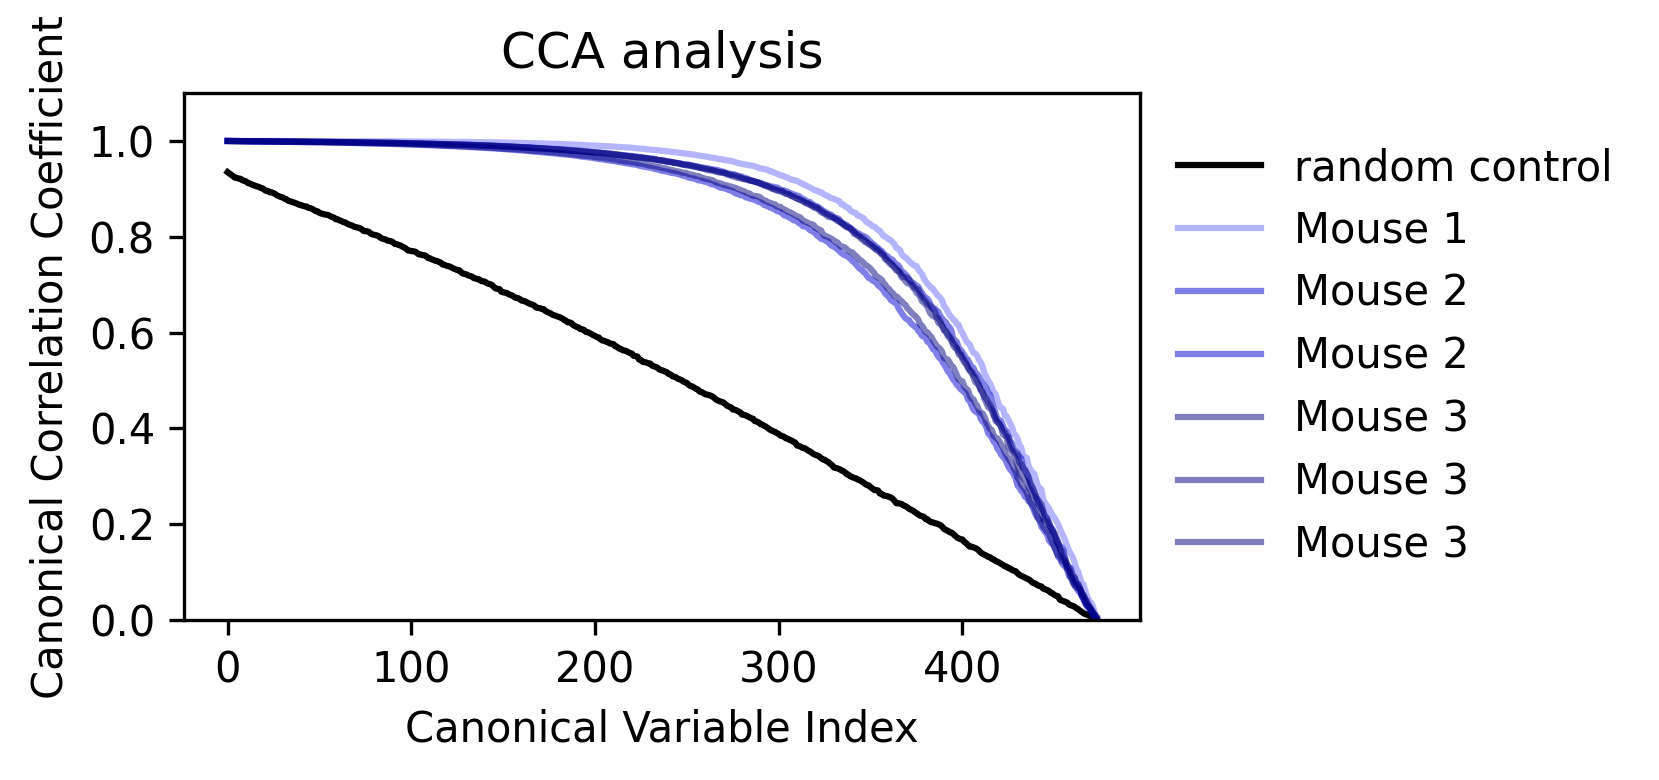

In [26]:
cca_comparison(rnn_models_dict)

### CCA by region

In [27]:
def plot_pca_by_region(real_data, rnn_data, original_shapes, regions, colours, mouse_num):
    num_plots = len(regions)
    labels = regions[:, 0]
    re_real_data = []
    re_rnn_data = []

    for r in range(len(regions)):
        re_real = np.split(real_data[r], np.cumsum(original_shapes)[:-1])
        re_rnn = np.split(rnn_data[r], np.cumsum(original_shapes)[:-1])

        # Try to convert to arrays if shapes match
        def safe_mean(trial_list):
            shapes = [arr.shape for arr in trial_list]
            if len(set(shapes)) == 1:
                return np.mean(np.array(trial_list), axis=0)
            else:
                print(f"Warning: Inconsistent trial lengths in region {labels[r]}; averaging manually.")
                # Truncate all to min length
                min_len = min(arr.shape[0] for arr in trial_list)
                truncated = np.array([arr[:min_len] for arr in trial_list])
                return np.mean(truncated, axis=0)

        mean_real = safe_mean(re_real)
        mean_rnn = safe_mean(re_rnn)

        re_real_data.append(mean_real)
        re_rnn_data.append(mean_rnn)

    fig = plt.figure(figsize=(10, 3))
    for r in range(num_plots):
        axn = fig.add_subplot(1, num_plots, r + 1)
        axn.plot(re_real_data[r][:, 0], re_real_data[r][:, 1], label='Experimental', linestyle='--', linewidth=3, color=colours['exp_color'])
        axn.plot(re_rnn_data[r][:, 0], re_rnn_data[r][:, 1], label='RNN model', linewidth=3, color=colours['model_color'])
        axn.set_xlabel('PC1')
        axn.set_ylabel('PC2')
        # axn.legend(fontsize=10, loc='upper left')
        axn.set_title(f"{labels[r]} activity", fontsize='xx-large')
        axn.spines['top'].set_visible(False)
        axn.spines['right'].set_visible(False)
        axn.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    fig.suptitle(f"Session {mouse_num}", fontsize=16)
    fig.tight_layout()
    return fig

def pca_by_region(data, regions, num_components):
    num_regions = len(regions)
    PCA_data = []
    pcas = []
    for r in range(num_regions):
        # select region data
        # neurons = len(regions[r][1])
        first_idx = regions[r][1][0]
        last_idx = regions[r][1][-1]
        region_data = data[:, first_idx:last_idx, ]
        # PCA and save
        pca = PCA(n_components=num_components)
        PCA_data.append(pca.fit_transform(region_data))
        pcas.append(pca)

    return PCA_data, pcas

def pca_regions_plt(rnn_model, pyal_dict, color_palette, mouse_num):
    rnn_model_ = rnn_model.copy()
    rnn_model_['RNN'] = rnnz.combine_rnn_time_bins(rnn_model)

    rnn_activity = rnn_model_['RNN'].T
    real_activity = rnn_model_['Adata'].T

    PCA_data_real, pcas_real = pca_by_region(real_activity, pyal_dict['regions_arr'])
    PCA_data_rnn, pcas_rnn = pca_by_region(rnn_activity, pyal_dict['regions_arr']) 
    _ = plot_pca_by_region(PCA_data_real, PCA_data_rnn, pyal_dict['shapes'], pyal_dict['regions_arr'], color_palette, mouse_num)   

In [37]:
def plot_cca_by_region(rnn_models, pyal_dicts, color_palette):

    fig = plt.figure(figsize=(4, 2.2),  dpi = 300)
    for m in range(len(rnn_models)):
        rnn_model = rnn_models[m]
        pyal_dict = pyal_dicts[m]

        rnn_model_ = rnn_model.copy()
        rnn_model_['RNN'] = rnnz.combine_rnn_time_bins(rnn_model)

        rnn_activity = rnn_model_['RNN'].T
        real_activity = rnn_model_['Adata'].T

        num_components = 58 # thats the minimum num of neurons over all mice and sessions

        PCA_data_real, pcas_real = pca_by_region(real_activity, pyal_dict['regions_arr'], num_components)
        PCA_data_rnn, pcas_rnn = pca_by_region(rnn_activity, pyal_dict['regions_arr'], num_components) 
        
        for i in range(len(PCA_data_real)):
            pca_data_real = PCA_data_real[i]
            pca_data_rnn = PCA_data_rnn[i]

            if m == 0 and i == 0: # just once
                shuffled_real = shuffle(rnn_activity, random_state=42)
                _, pca_shuffled_real = analyz.pca_fit_transform(shuffled_real, num_components)
                ctrl_cca = analyz.canoncorr(pca_data_real, pca_shuffled_real)
                plt.plot(ctrl_cca[:100], label = "control", color = 'black')

            area = pyal_dict['areas'][i].split("_")[0]
            model_cca = analyz.canoncorr(pca_data_real, pca_data_rnn) 
            plt.plot(model_cca[:100], label = area, color = color_palette['curbd_colors'][area], alpha = 0.7)
            
    # plt.legend(frameon=False, fontsize = 12, bbox_to_anchor=(1.05, 1))
    plt.ylim(0, 1.1)
    plt.show()
    

In [38]:
models = [rnn_model, rnn_model0, rnn_model1, rnn_model2, rnn_model3, rnn_model4]
pyal_dicts = [pyal_dict_44_0, pyal_dict_61_0, pyal_dict_61_1, pyal_dict_62_0, pyal_dict_62_1, pyal_dict_62_2]

RNN model output transformed from shape: (474, 2925) to (474, 1463). Matching the original data shape of (474, 1463)
RNN model output transformed from shape: (861, 4799) to (861, 2400). Matching the original data shape of (861, 2400)
RNN model output transformed from shape: (587, 4799) to (587, 2400). Matching the original data shape of (587, 2400)
RNN model output transformed from shape: (810, 4799) to (810, 2400). Matching the original data shape of (810, 2400)
RNN model output transformed from shape: (792, 4799) to (792, 2400). Matching the original data shape of (792, 2400)
RNN model output transformed from shape: (647, 4799) to (647, 2400). Matching the original data shape of (647, 2400)


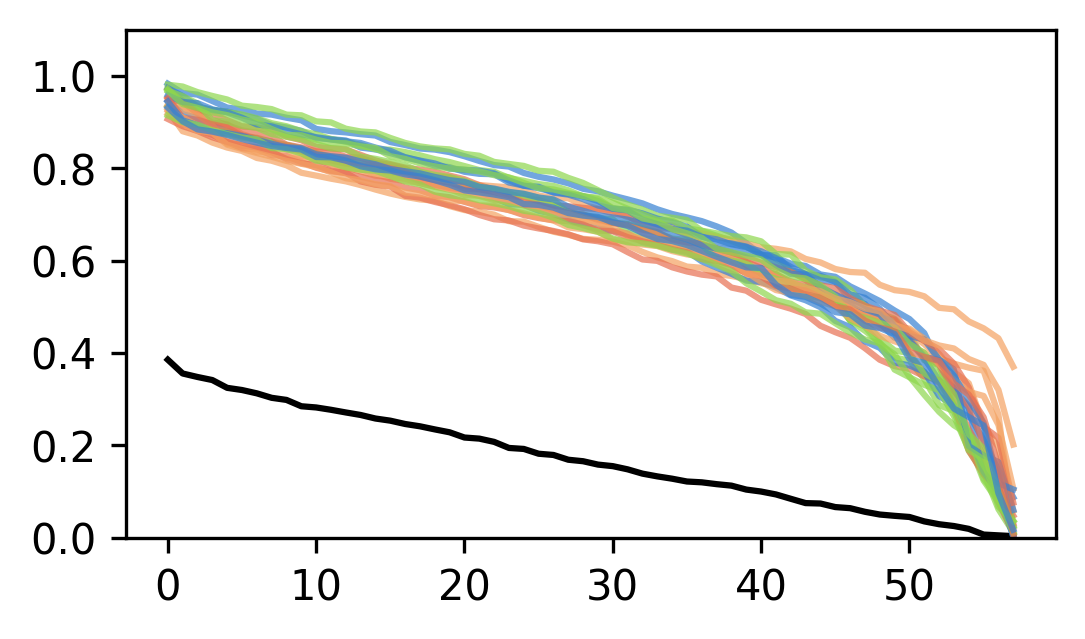

In [39]:
plot_cca_by_region(models, pyal_dicts, color_palette)